# FAI Homework 9

**FBA Quant 이의형**

---

## Problem 1. Neural Network for Prediction

---

**(a)** Use LSTM to predict future stock price. Predict next day KOSPI index based on last 20 days value.

### setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# from krx import WebSource

# kws = WebSource()
# kws.set_freq(1)

In [2]:
kospi = pd.read_csv('FAI_HW9_DATA_KOSPI.csv', index_col=0)
kospi

,close
date,
2003-01-02,635.17
2003-01-03,661.10
2003-01-06,666.71
2003-01-07,652.20
2003-01-08,651.72
...,...
2023-12-19,2568.55
2023-12-20,2614.30
2023-12-21,2600.02


### Preprocessing

In [3]:
from sklearn.preprocessing import MinMaxScaler


def create_dataset(data, time_step=20):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

data = kospi.values
train_size = int(len(data) * 0.4)
valid_size = int(len(data) * 0.8)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[:train_size])
data = scaler.transform(data)

time_step = 20
X, y = create_dataset(data, time_step)

X_train, X_val, X_test = X[:train_size,:], X[train_size:valid_size,:], X[valid_size:,:]
y_train, y_val, y_test = y[:train_size], y[train_size:valid_size], y[valid_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, X_val.shape, X_test.shape

((2076, 20, 1), (2076, 20, 1), (1018, 20, 1))

### training

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(20,1)))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, callbacks=[early_stopping])

Epoch 1/100
2076/2076 [==============================] - 23s 10ms/step - loss: 0.0027 - val_loss: 9.2490e-04
Epoch 2/100
2076/2076 [==============================] - 19s 9ms/step - loss: 6.7464e-04 - val_loss: 0.0037
Epoch 3/100
2076/2076 [==============================] - 20s 9ms/step - loss: 5.1941e-04 - val_loss: 7.7400e-04
Epoch 4/100
2076/2076 [==============================] - 20s 10ms/step - loss: 4.1246e-04 - val_loss: 0.0030
Epoch 5/100
2076/2076 [==============================] - 19s 9ms/step - loss: 3.1309e-04 - val_loss: 1.3998e-04
Epoch 6/100
2076/2076 [==============================] - 20s 9ms/step - loss: 2.7517e-04 - val_loss: 6.5173e-04
Epoch 7/100
2076/2076 [==============================] - 18s 9ms/step - loss: 2.5967e-04 - val_loss: 1.3481e-04
Epoch 8/100
2076/2076 [==============================] - 19s 9ms/step - loss: 2.4116e-04 - val_loss: 4.2761e-04
Epoch 9/100
2076/2076 [==============================] - 20s 9ms/step - loss: 2.2571e-04 - val_loss: 3.9205e-04
Ep

In [5]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_val)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
valid_predict = scaler.inverse_transform(valid_predict)
test_predict = scaler.inverse_transform(test_predict)

predict_value = np.concatenate((train_predict.reshape(-1), valid_predict.reshape(-1), test_predict.reshape(-1)))
predict_value.shape

32/32 [==============================] - 0s 4ms/step


(5170,)

In [6]:
plot_df = kospi.iloc[time_step:].copy()
plot_df.rename(columns={'close':'true_value'}, inplace=True)
plot_df.index = pd.to_datetime(plot_df.index)
plot_df['predict_value'] = predict_value
plot_df

,true_value,predict_value
date,,
2003-01-30,591.86,604.307312
2003-02-03,600.41,610.718262
2003-02-04,603.78,619.855408
2003-02-05,600.68,623.039368
2003-02-06,589.50,619.142578
...,...,...
2023-12-19,2568.55,2524.399902
2023-12-20,2614.30,2527.332275
2023-12-21,2600.02,2564.854980


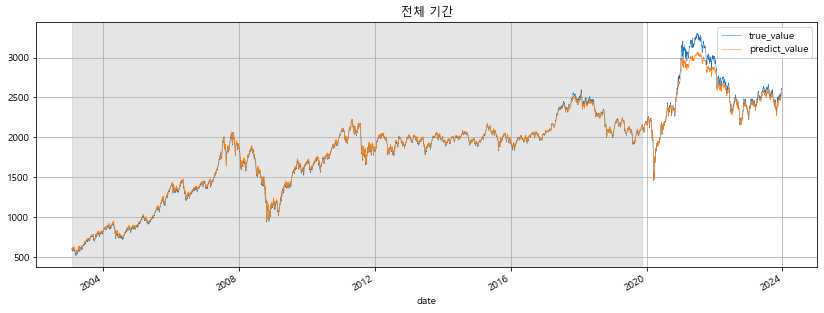

In [7]:
ax = plot_df.plot(figsize=(14,5), title='전체 기간', grid=True, linewidth=0.5)
ax = ax.axvspan(plot_df.index[0], plot_df.index[valid_size],color='gray', alpha=0.2)

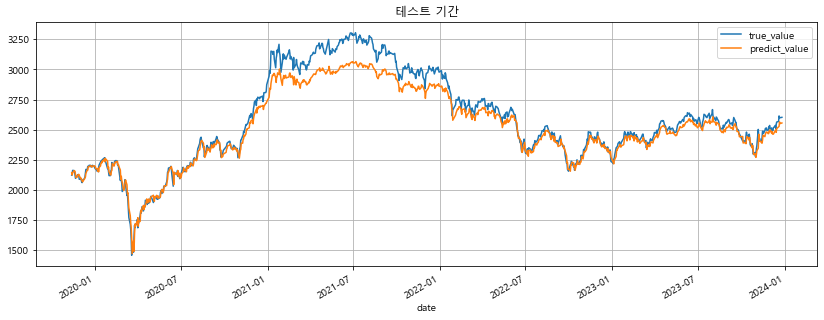

In [8]:
plot_df.iloc[valid_size:,:].plot(figsize=(14,5), title='테스트 기간', grid=True);

In [9]:
test_rtn = plot_df.iloc[valid_size:,:].pct_change(1, axis=0).iloc[1:]
test_rtn['is_direction_answer'] = test_rtn.apply(lambda s: (s.loc['true_value'] * s.loc['predict_value']) > 0, axis=1)
test_rtn.is_direction_answer.sum() / test_rtn.shape[0]

0.5181907571288102

---

**(b)** Report key features you could find from your LSTM model.

차트를 보면 값을 잘 따라가는 것처럼 보이지만, 실제로 일별 등락을 맞춘 날은 52% 정도이다.

---

**(c)** Use LSTM to predict future stock return. Predict next day return of KOSPI based on last 20 daily return.

In [10]:
rtn_1d = kospi.pct_change(1, axis=0).iloc[1:].values

train_size = int(len(rtn_1d) * 0.4)
valid_size = int(len(rtn_1d) * 0.8)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rtn_1d[:train_size])
rtn_1d = scaler.transform(rtn_1d)

time_step = 20
X, y = create_dataset(rtn_1d, time_step)

X_train, X_val, X_test = X[:train_size,:], X[train_size:valid_size,:], X[valid_size:,:]
y_train, y_val, y_test = y[:train_size], y[train_size:valid_size], y[valid_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, X_val.shape, X_test.shape
X_train.shape, X_test.shape

((2075, 20, 1), (1018, 20, 1))

In [11]:
rtn_model = Sequential()
rtn_model.add(LSTM(20, return_sequences=True, input_shape=(20,1)))
rtn_model.add(LSTM(20, return_sequences=False))
rtn_model.add(Dense(1))

rtn_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
rtn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=1, callbacks=[early_stopping])

Epoch 1/100
2075/2075 [==============================] - 21s 9ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 2/100
2075/2075 [==============================] - 19s 9ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 3/100
2075/2075 [==============================] - 19s 9ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 4/100
2075/2075 [==============================] - 20s 10ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 5/100
2075/2075 [==============================] - 20s 10ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 6/100
2075/2075 [==============================] - 20s 10ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 7/100
2075/2075 [==============================] - 19s 9ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 8/100
2075/2075 [==============================] - 19s 9ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 9/100
2075/2075 [==============================] - 19s 9ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 10/100
2075/2075 [==============================] - 19s

In [12]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_val)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
valid_predict = scaler.inverse_transform(valid_predict)
test_predict = scaler.inverse_transform(test_predict)

predict_value = np.concatenate((train_predict.reshape(-1), valid_predict.reshape(-1), test_predict.reshape(-1)))
predict_value.shape

32/32 [==============================] - 0s 4ms/step


(5169,)

In [13]:
plot_df = kospi.iloc[time_step:].pct_change(1, axis=0).iloc[1:].copy()
plot_df.rename(columns={'close':'true_value'}, inplace=True)
plot_df.index = pd.to_datetime(plot_df.index)
plot_df['predict_value'] = predict_value
plot_df

,true_value,predict_value
date,,
2003-02-03,0.014446,0.018110
2003-02-04,0.005613,0.015716
2003-02-05,-0.005134,0.008049
2003-02-06,-0.018612,-0.003070
2003-02-07,-0.020390,-0.016959
...,...,...
2023-12-19,0.000658,0.003679
2023-12-20,0.017812,0.002792
2023-12-21,-0.005462,0.020387


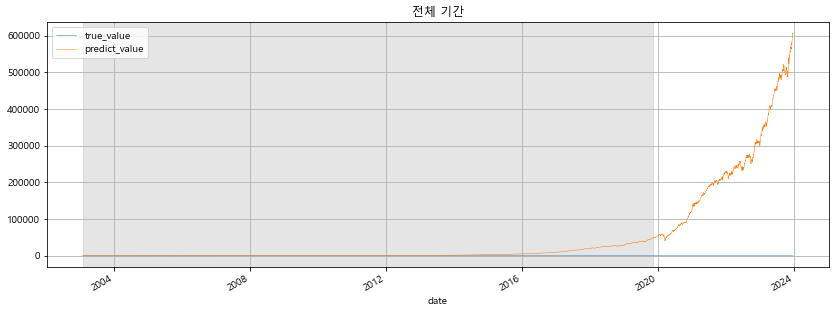

In [14]:
cum_rtn_df = (plot_df + 1).cumprod(axis=0) - 1
ax = cum_rtn_df.plot(figsize=(14,5), title='전체 기간', grid=True, linewidth=0.5)
ax = ax.axvspan(cum_rtn_df.index[0], cum_rtn_df.index[valid_size],color='gray', alpha=0.2)

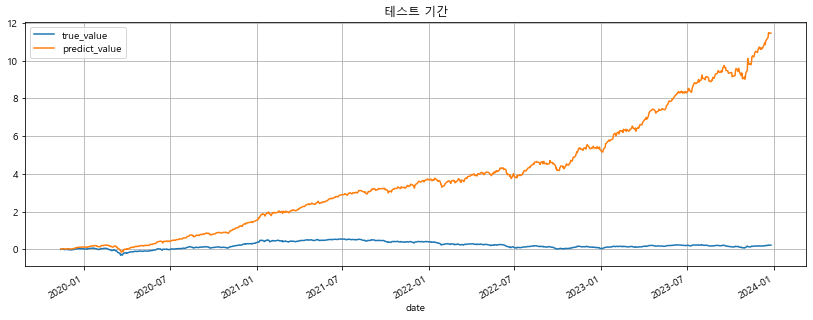

In [15]:
test_cum_rtn_df = (plot_df.iloc[valid_size:,:] + 1).cumprod(axis=0) - 1
test_cum_rtn_df.plot(figsize=(14,5), title='테스트 기간', grid=True);

In [16]:
test_rtn = plot_df.iloc[valid_size:,:].copy()
test_rtn['is_direction_answer'] = test_rtn.apply(lambda s: (s.loc['true_value'] * s.loc['predict_value']) > 0, axis=1)
test_rtn.is_direction_answer.sum() / test_rtn.shape[0]

0.5314341846758349

---

**(d)** Report key features you could find from your LSTM model.

수익률로 예측해도 성과는 크게 달라지지 않는다.

---

## Problem 2. Neural Network for Portfolio Optimization

---

**(a)** Refer https://github.com/shilewenuw/deep-learning-portfolio-optimization and apply it to Korean stock market, use [clean_adj_close.csv]

In [17]:
import numpy as np

# setting the seed allows for reproducible results
np.random.seed(33)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

import pandas as pd

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [18]:
import yfinance as yf

start = '2017-01-01'
end = '2023-12-27'
symbols = ['153130.KS', # 채권
          '226490.KS', # 코스피
          '261220.KS', # 원유
          'VIXY']

close_price = yf.download(symbols, start, end).Close
close_price

[*********************100%***********************]  4 of 4 completed


,153130.KS,226490.KS,261220.KS,VIXY
Date,,,,
2017-01-02,100040.0,20620.0,20345.0,NaN
2017-01-03,100050.0,20765.0,20360.0,1579.199951
2017-01-04,100065.0,20725.0,19900.0,1499.199951
2017-01-05,100085.0,20700.0,20045.0,1492.800049
2017-01-06,100095.0,20810.0,20225.0,1474.400024
...,...,...,...,...
2023-12-19,108130.0,26260.0,13715.0,16.389999
2023-12-20,108150.0,26730.0,13970.0,17.400000
2023-12-21,108185.0,26560.0,13965.0,16.969999


In [19]:
# 직전 1년 변동성 기반 1개월마다 리밸런싱

def equal_weight(buy_basket_rtn_1d):
    stock_cnt = buy_basket_rtn_1d.shape[1]
    weights = np.ones(stock_cnt) / stock_cnt
    return weights

def lstm_weight(buy_basket_price):
    pf_model = Model()
    weights = pf_model.get_allocations(buy_basket_price.dropna())
    return weights

def portfolio_optimization_backtest(weights_func, buy_basket_price, forward=False):
    trading_days = 250
    start_date = buy_basket_price.index[trading_days]
    end_date = buy_basket_price.index[-1]
    
    first_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    rebal_dates = [ buy_basket_price.loc[fd:,:].iloc[0,:].name for fd in first_dates]
    
    rtn_1d = buy_basket_price.pct_change(1, axis=0)
    daily_rtn = pd.Series(dtype = np.float64).reindex_like(rtn_1d.iloc[:,0])
    
    finish = rebal_dates[-1].strftime('%Y-%m-%d')
    for rd_idx in range(len(rebal_dates)-1):
        buy_date = rebal_dates[rd_idx]
        sell_date = rebal_dates[rd_idx+1]
        
        buy_basket_rtn_1d = rtn_1d.loc[buy_date:sell_date,:].iloc[1:]
        if forward:
            sample_period_price = buy_basket_price.loc[:buy_date,:].iloc[-trading_days:-2]
            weights = weights_func(sample_period_price.dropna())
        else:
            weights = weights_func(buy_basket_rtn_1d)
        period_rtn_1d = buy_basket_rtn_1d.values @ weights
        
        daily_rtn.loc[buy_date:sell_date].iloc[1:] = period_rtn_1d.reshape(-1)
        print(f"{sell_date.strftime('%Y-%m-%d')} / {finish}")
    daily_rtn.dropna(inplace=True)
    return daily_rtn

def rtn_analysis(daily_rtn):
    cumprod_rtn = (daily_rtn + 1).cumprod()
    cumprod_high = cumprod_rtn.cummax()
    
    annual_rtn = daily_rtn.mean() * 252
    annual_std = daily_rtn.std() * np.sqrt(252)
    sharpe = annual_rtn / annual_std
    dd = cumprod_rtn / cumprod_high - 1
    
    print(f'Annualized mean return       : {annual_rtn:.4f}')
    print(f'Annualized standard deviation: {annual_std:.4f}')
    print(f'Sharpe ratio                 : {sharpe:.4f}')
    print(f'Maximum DrawDown             : {dd.min():.4f}')

In [20]:
opt_models = {
    'lstm': lstm_weight,
    'equal': equal_weight
}
model_rtn_df = pd.DataFrame(index=close_price.index, columns = opt_models.keys())
for model in opt_models:
    print(f'- {model.upper()} -')
    model_rtn_df.loc[:,model] = portfolio_optimization_backtest(opt_models[model], close_price, forward=True)

- LSTM -
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0522
Epoch 2/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0493
Epoch 3/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0463
Epoch 4/20
1/1 [==============================] - 0s 40ms/step - loss: 0.0434
Epoch 5/20
1/1 [==============================] - 0s 49ms/step - loss: 0.0405
Epoch 6/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0376
Epoch 7/20
1/1 [==============================] - 0s 45ms/step - loss: 0.0347
Epoch 8/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0318
Epoch 9/20
1/1 [==============================] - 0s 46ms/step - loss: 0.0289
Epoch 10/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0260
Epoch 11/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0232
Epoch 12/20
1/1 [==============================] - 0s 50ms/step - loss: 0.0204
Epoch 13/20
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 361ms/step
2018-10-01 / 2023-12-01
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0387
Epoch 2/20
1/1 [==============================] - 0s 46ms/step - loss: -0.0400
Epoch 3/20
1/1 [==============================] - 0s 46ms/step - loss: -0.0413
Epoch 4/20
1/1 [==============================] - 0s 45ms/step - loss: -0.0427
Epoch 5/20
1/1 [==============================] - 0s 51ms/step - loss: -0.0440
Epoch 6/20
1/1 [==============================] - 0s 59ms/step - loss: -0.0453
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: -0.0467
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: -0.0480
Epoch 9/20
1/1 [==============================] - 0s 55ms/step - loss: -0.0494
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: -0.0508
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: -0.0521
Epoch 12/20
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 52ms/step - loss: 0.0365
Epoch 19/20
1/1 [==============================] - 0s 58ms/step - loss: 0.0359
Epoch 20/20
1/1 [==============================] - 0s 425ms/step
2019-08-01 / 2023-12-01
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0604
Epoch 2/20
1/1 [==============================] - 0s 40ms/step - loss: 0.0598
Epoch 3/20
1/1 [==============================] - 0s 42ms/step - loss: 0.0592
Epoch 4/20
1/1 [==============================] - 0s 39ms/step - loss: 0.0585
Epoch 5/20
1/1 [==============================] - 0s 42ms/step - loss: 0.0579
Epoch 6/20
1/1 [==============================] - 0s 46ms/step - loss: 0.0572
Epoch 7/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0565
Epoch 8/20
1/1 [==============================] - 0s 45ms/step - loss: 0.0558
Epoch 9/20
1/1 [==============================] - 0s 45ms/step - loss: 0.0551
Epoch 10/20
1/1 [==============================] - 0s 44ms/step -

Epoch 16/20
1/1 [==============================] - 0s 43ms/step - loss: -0.0315
Epoch 17/20
1/1 [==============================] - 0s 48ms/step - loss: -0.0318
Epoch 18/20
1/1 [==============================] - 0s 45ms/step - loss: -0.0320
Epoch 19/20
1/1 [==============================] - 0s 46ms/step - loss: -0.0323
Epoch 20/20
1/1 [==============================] - 0s 316ms/step
2020-06-01 / 2023-12-01
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0913
Epoch 2/20
1/1 [==============================] - 0s 46ms/step - loss: 0.0906
Epoch 3/20
1/1 [==============================] - 0s 45ms/step - loss: 0.0899
Epoch 4/20
1/1 [==============================] - 0s 47ms/step - loss: 0.0892
Epoch 5/20
1/1 [==============================] - 0s 46ms/step - loss: 0.0884
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 0.0876
Epoch 7/20
1/1 [==============================] - 0s 45ms/step - loss: 0.0868
Epoch 8/20
1/1 [==============================]

1/1 [==============================] - 0s 103ms/step - loss: -0.0702
Epoch 13/20
1/1 [==============================] - 0s 100ms/step - loss: -0.0720
Epoch 14/20
1/1 [==============================] - 0s 81ms/step - loss: -0.0738
Epoch 15/20
1/1 [==============================] - 0s 68ms/step - loss: -0.0756
Epoch 16/20
1/1 [==============================] - 0s 47ms/step - loss: -0.0774
Epoch 17/20
1/1 [==============================] - 0s 47ms/step - loss: -0.0791
Epoch 18/20
1/1 [==============================] - 0s 55ms/step - loss: -0.0809
Epoch 19/20
1/1 [==============================] - 0s 87ms/step - loss: -0.0826
Epoch 20/20
1/1 [==============================] - 1s 559ms/step
2021-04-01 / 2023-12-01
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: -0.0216
Epoch 2/20
1/1 [==============================] - 0s 62ms/step - loss: -0.0242
Epoch 3/20
1/1 [==============================] - 0s 60ms/step - loss: -0.0267
Epoch 4/20
1/1 [==============================

1/1 [==============================] - 0s 70ms/step - loss: 0.0408
Epoch 9/20
1/1 [==============================] - 0s 92ms/step - loss: 0.0395
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 0.0381
Epoch 11/20
1/1 [==============================] - 0s 87ms/step - loss: 0.0366
Epoch 12/20
1/1 [==============================] - 0s 89ms/step - loss: 0.0352
Epoch 13/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0338
Epoch 14/20
1/1 [==============================] - 0s 81ms/step - loss: 0.0323
Epoch 15/20
1/1 [==============================] - 0s 61ms/step - loss: 0.0308
Epoch 16/20
1/1 [==============================] - 0s 100ms/step - loss: 0.0293
Epoch 17/20
1/1 [==============================] - 0s 62ms/step - loss: 0.0278
Epoch 18/20
1/1 [==============================] - 0s 72ms/step - loss: 0.0262
Epoch 19/20
1/1 [==============================] - 0s 91ms/step - loss: 0.0246
Epoch 20/20
1/1 [==============================] - 1s 566ms/step

Epoch 7/20
1/1 [==============================] - 0s 82ms/step - loss: -0.0746
Epoch 8/20
1/1 [==============================] - 0s 64ms/step - loss: -0.0755
Epoch 9/20
1/1 [==============================] - 0s 86ms/step - loss: -0.0764
Epoch 10/20
1/1 [==============================] - 0s 81ms/step - loss: -0.0772
Epoch 11/20
1/1 [==============================] - 0s 86ms/step - loss: -0.0780
Epoch 12/20
1/1 [==============================] - 0s 85ms/step - loss: -0.0788
Epoch 13/20
1/1 [==============================] - 0s 92ms/step - loss: -0.0796
Epoch 14/20
1/1 [==============================] - 0s 88ms/step - loss: -0.0803
Epoch 15/20
1/1 [==============================] - 0s 80ms/step - loss: -0.0811
Epoch 16/20
1/1 [==============================] - 0s 83ms/step - loss: -0.0818
Epoch 17/20
1/1 [==============================] - 0s 88ms/step - loss: -0.0824
Epoch 18/20
1/1 [==============================] - 0s 89ms/step - loss: -0.0831
Epoch 19/20
1/1 [==========================

1/1 [==============================] - 0s 83ms/step - loss: 0.0535
Epoch 5/20
1/1 [==============================] - 0s 90ms/step - loss: 0.0532
Epoch 6/20
1/1 [==============================] - 0s 110ms/step - loss: 0.0529
Epoch 7/20
1/1 [==============================] - 0s 109ms/step - loss: 0.0526
Epoch 8/20
1/1 [==============================] - 0s 90ms/step - loss: 0.0522
Epoch 9/20
1/1 [==============================] - 0s 95ms/step - loss: 0.0519
Epoch 10/20
1/1 [==============================] - 0s 97ms/step - loss: 0.0516
Epoch 11/20
1/1 [==============================] - 0s 93ms/step - loss: 0.0513
Epoch 12/20
1/1 [==============================] - 0s 89ms/step - loss: 0.0510
Epoch 13/20
1/1 [==============================] - 0s 86ms/step - loss: 0.0507
Epoch 14/20
1/1 [==============================] - 0s 100ms/step - loss: 0.0503
Epoch 15/20
1/1 [==============================] - 0s 97ms/step - loss: 0.0500
Epoch 16/20
1/1 [==============================] - 0s 103ms/step -

- lstm -
Annualized mean return       : -0.0786
Annualized standard deviation: 0.2500
Sharpe ratio                 : -0.3145
Maximum DrawDown             : -0.5573

- equal -
Annualized mean return       : -0.0496
Annualized standard deviation: 0.2162
Sharpe ratio                 : -0.2295
Maximum DrawDown             : -0.4795



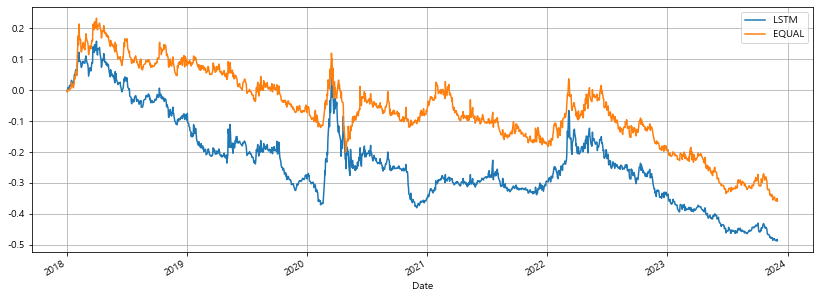

In [21]:
for model in opt_models:
    print(f'- {model} -')
    rtn_analysis(model_rtn_df.loc[:,model])
    cum_rtn = (model_rtn_df.loc[:,model] + 1).cumprod() - 1
    cum_rtn.plot(figsize=(14,5), label = model.upper(), legend = True, grid=True);
    print()

---